<p style="background:#83739E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b>Risk Evaluation for Retail Banks</b><br>
    <br>Model Selection and Testing<br><br> 
</p>

<p style="text-align: right;">Module 4: Machine Learning<br>
Sprint 4: Machine Learning Capstone Project<br>
Author : Renato Mariano</p>

<h1 style="color:#774CAD">Introduction </h1>

Welcome to the Capstone Project of of the Machine Learning Module! In this sprint, we embark on an exciting journey to develop a **risk evaluation service for retail banks**, leveraging the power of data science and machine learning.

This work is part of a series of notebooks starting with 01_EDA_application.

<h2 style="color:#774CAD">Library Imports and Notebook Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from rapidfuzz import process
import re

from utils import utils
from utils import EDA
from feature_models import feat_eng
from feature_models import pipelines
from feature_models import model_select

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight
from scipy.stats import randint, uniform

from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, recall_score, make_scorer, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics import precision_recall_curve
import shap

In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

%load_ext blackcellmagic

<h1 style="color:#774CAD">Data Transformations</h1>

We start by loading our dataframes and applying our changes / pipelines to the data. We also read our test dataset and apply the same changes to it.

In [3]:
df_train = utils.load_df(file_path="data/df_train.csv")
df_valid = utils.load_df(file_path="data/df_validation.csv")
df_test = utils.load_df(file_path="data/df_test.csv")

df_previous = utils.load_df(file_path="data/home-credit-default-risk/previous_application.csv")
df_installments = utils.load_df(file_path="data/home-credit-default-risk/installments_payments.csv")
df_bureau = utils.load_df(file_path="data/home-credit-default-risk/bureau.csv")
feats_to_keep = utils.load_df(file_path="data/feats_to_keep.csv")

The shape of the data is: (153755, 122)
load_df took 2.215 seconds

The shape of the data is: (61502, 122)
load_df took 0.864 seconds

The shape of the data is: (92254, 122)
load_df took 1.203 seconds

The shape of the data is: (1670214, 37)
load_df took 10.071 seconds

The shape of the data is: (13605401, 8)
load_df took 19.058 seconds

The shape of the data is: (1716428, 17)
load_df took 4.974 seconds

The shape of the data is: (37, 1)
load_df took 0.003 seconds



In [6]:
df_previous_transf = feat_eng.PreviousApplicationTransformer().fit_transform(df_previous)
df_installments_transf = feat_eng.InstallmentsTransformer().fit_transform(df_installments)
df_bureau_transf = feat_eng.BureauTransformer().fit_transform(df_bureau)

In [7]:
def preprocess_and_drop_features(
    df, df_previous_transf, df_installments_transf, df_bureau_transf, feats_to_keep
):
    df_transformed = df.merge(df_previous_transf, on="SK_ID_CURR", how="left").merge(
        df_installments_transf, on="SK_ID_CURR", how="left"
    ).merge(
        df_bureau_transf, on="SK_ID_CURR", how="left"
    )

    X = df_transformed.drop(["TARGET", "SK_ID_CURR"], axis=1)
    y = df_transformed["TARGET"]

    feat_eng_pipe2 = Pipeline(
    steps=[
        ('zero_null_transformer', feat_eng.ZeroToNullTransformer(columns="YEARS_BEGINEXPLUATATION_MEDI")),
        ('multiply_by_neg1', feat_eng.MultiplyByNeg1(columns=[col for col in df.columns if col.startswith('DAYS_')])),
        ('days_empl_anomaly', feat_eng.HandleDaysEmployedAnomaly()),
        ('map_loan_titles', feat_eng.ApplyMapToOrganization(column="ORGANIZATION_TYPE", similarity_threshold=70)),
        ('ext_sources_transformer', feat_eng.ExternalSourcesTransformer()),
        ('financial_ratio_transformer', feat_eng.FinancialRatioTransformer()),
        ('age_employment_transformer', feat_eng.AgeAndEmploymentTransformer()),
        ]
    )

    X_FE = feat_eng_pipe2.fit_transform(X)
    num_feats, cat_feats, binary_feats, highcard_feats = utils.extract_features(X_FE)

    preprocess_pipe = pipelines.create_preprocess_pipeline(
        num_feats, binary_feats, highcard_feats
    )
    X_ready = preprocess_pipe.fit_transform(X_FE)

    # Keep selected columns and rename because of LGMB error.
    X_ready = X_ready.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '_', x))
    X_ready = X_ready[feats_to_keep["Feature"].to_list()]
    
    return X_ready, y

In [8]:
X_train, y_train = preprocess_and_drop_features(
    df=df_train,
    df_previous_transf=df_previous_transf,
    df_installments_transf=df_installments_transf,
    df_bureau_transf=df_bureau_transf,
    feats_to_keep=feats_to_keep,
)
print(X_train.shape, y_train.size)
X_train.head(3)

(153755, 37) 153755


,num__AMT_CREDIT,num__AMT_ANNUITY,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__OWN_CAR_AGE,num__REGION_RATING_CLIENT,num__REG_CITY_NOT_LIVE_CITY,num__EXT_SOURCE_2,num__EXT_SOURCE_3,num__PREV_name_contract_refused,...,num__BU_debt_credit_sum_ratio_max,num__EXT_SOURCES_prod,num__EXT_SOURCES_sum,num__EXT_SOURCES_mean,num__amt_credit_annuity_ratio,num__amt_goods_price_annuity_ratio,num__amt_goods_price_credit_ratio,num__amt_goods_price_children_ratio,num__days_employed_percent,cat__NAME_EDUCATION_TYPE_Higher_education
0,-0.618,-0.878,-0.969,-0.244,NaN,1.000,1.000,-1.375,NaN,0.500,...,NaN,-0.754,-1.353,-1.848,0.000,0.056,0.642,-0.337,0.023,0.000
1,1.246,0.545,0.012,-0.179,0.300,-1.000,1.000,0.152,NaN,NaN,...,-0.796,0.393,-0.013,0.204,1.229,0.742,-0.671,0.269,-0.256,1.000
2,1.918,0.885,-0.368,0.441,NaN,0.000,0.000,0.046,0.197,NaN,...,-0.758,-0.145,0.856,0.184,1.554,1.391,-0.125,0.721,0.542,1.000


In [9]:
X_valid, y_valid = preprocess_and_drop_features(
    df=df_valid,
    df_previous_transf=df_previous_transf,
    df_installments_transf=df_installments_transf,
    df_bureau_transf=df_bureau_transf,
    feats_to_keep=feats_to_keep,
)
print(X_valid.shape, y_valid.size)
X_valid.head(3)

(61502, 37) 61502


,num__AMT_CREDIT,num__AMT_ANNUITY,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__OWN_CAR_AGE,num__REGION_RATING_CLIENT,num__REG_CITY_NOT_LIVE_CITY,num__EXT_SOURCE_2,num__EXT_SOURCE_3,num__PREV_name_contract_refused,...,num__BU_debt_credit_sum_ratio_max,num__EXT_SOURCES_prod,num__EXT_SOURCES_sum,num__EXT_SOURCES_mean,num__amt_credit_annuity_ratio,num__amt_goods_price_annuity_ratio,num__amt_goods_price_credit_ratio,num__amt_goods_price_children_ratio,num__days_employed_percent,cat__NAME_EDUCATION_TYPE_Higher_education
0,1.258,0.556,-0.392,-0.495,NaN,-1.000,0.000,-1.131,-0.489,-0.500,...,-0.799,-0.426,-0.766,-0.946,1.222,0.740,-0.671,1.282,-0.517,1.000
1,1.890,0.960,0.870,NaN,NaN,-1.000,0.000,0.600,-0.651,NaN,...,0.040,0.125,-0.114,0.049,1.411,1.717,0.642,2.573,NaN,0.000
2,0.017,0.575,-0.016,-0.289,NaN,0.000,0.000,-0.629,-0.613,NaN,...,0.266,-0.283,-0.612,-0.712,-0.453,-0.680,-0.185,0.243,-0.359,0.000


In [10]:
X_test, y_test= preprocess_and_drop_features(
    df=df_test,
    df_previous_transf=df_previous_transf,
    df_installments_transf=df_installments_transf,
    df_bureau_transf=df_bureau_transf,
    feats_to_keep=feats_to_keep,
)
print(X_test.shape, y_test.size)
X_test.head(3)

(92254, 37) 92254


,num__AMT_CREDIT,num__AMT_ANNUITY,num__DAYS_BIRTH,num__DAYS_EMPLOYED,num__OWN_CAR_AGE,num__REGION_RATING_CLIENT,num__REG_CITY_NOT_LIVE_CITY,num__EXT_SOURCE_2,num__EXT_SOURCE_3,num__PREV_name_contract_refused,...,num__BU_debt_credit_sum_ratio_max,num__EXT_SOURCES_prod,num__EXT_SOURCES_sum,num__EXT_SOURCES_mean,num__amt_credit_annuity_ratio,num__amt_goods_price_annuity_ratio,num__amt_goods_price_credit_ratio,num__amt_goods_price_children_ratio,num__days_employed_percent,cat__NAME_EDUCATION_TYPE_Higher_education
0,-0.591,-0.740,0.845,NaN,-0.400,0.000,0.000,0.074,0.828,NaN,...,-0.797,0.922,0.356,0.766,-0.242,-0.589,-0.621,-0.386,NaN,0.000
1,-0.187,-0.121,-0.598,0.425,NaN,1.000,0.000,0.373,0.030,NaN,...,-0.167,0.557,0.107,0.388,-0.146,-0.368,-0.185,0.043,0.706,0.000
2,1.044,0.367,0.490,-0.550,-0.300,0.000,0.000,0.465,-0.867,-0.500,...,0.280,-0.247,0.964,0.295,1.238,1.480,0.642,1.567,-0.625,0.000


<h1 style="color:#774CAD">Model Selection</h1>

The following modeling solutions were defined. We start off by **setting the hyperparameters for the RandomSearch** for each of the defined models. The GridSearch is the responsible to find the best hyperparameters for each model while **it performs a cross-validation**. We used 5 cross-folds.

In [11]:
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight = {0: class_weights[0], 1: class_weights[1]}

param_distributions = {
    'DecisionTree': {
        'model__max_depth': randint(3, 10),
        'model__min_samples_leaf': randint(30, 101)
    },
    'XGBoost': {
        'model__n_estimators': randint(10, 51),
        'model__learning_rate': uniform(0.01, 0.05),
        'model__max_depth': randint(3, 10)
    },
    'LGBM': {
        'model__n_estimators': randint(10, 51),
        'model__learning_rate': uniform(0.01, 0.05),
        'model__max_depth': randint(3, 10),
        'model__class_weight': [None, class_weight]
    },
    'CatBoost': {
        'model__iterations': randint(10, 51),
        'model__learning_rate': uniform(0.01, 0.05),
        'model__depth': randint(3, 10),
        'model__class_weights': [None, class_weight]
    },
}

models = [
    ('DecisionTree', DecisionTreeClassifier(random_state=1, class_weight='balanced')),
    ('XGBoost', XGBClassifier(random_state=1, class_weight=class_weight)), 
    ('LGBM', LGBMClassifier(random_state=1, class_weight='balanced', verbose=-1)),
    ('CatBoost', CatBoostClassifier(random_state=1, class_weights=class_weight, verbose=False)),
]


In [12]:
results = {}
feat_importance_result = {}

for model_name, model in models:
    model_pipeline = Pipeline([
        ('model', model)
    ])

    param_dist = param_distributions.get(model_name, {})
    randomized_search = RandomizedSearchCV(model_pipeline, param_distributions=param_dist, n_iter=10, cv=5, scoring="roc_auc", random_state=1)
    randomized_search.fit(X_train, y_train)
        
    results[model_name] = {
        'model': randomized_search.best_estimator_,
        'best_params': randomized_search.best_params_,
        'best_score': randomized_search.best_score_,
    }



In [13]:
#results

In [20]:
print("Model ROC AUC-Scores:")
for model_name, result in results.items():
    print(f"{model_name}: {result['best_score']:.3}")

Model ROC AUC-Scores:
DecisionTree: 0.721
XGBoost: 0.761
LGBM: 0.756
CatBoost: 0.756


Solely based on the results of the training set for ROC AUC, we see that our models have similar prediction power, with values above 0.72 for this metric.

Using the validation dataset, let's define variables for our best models and generate these ROC AUC curves.

In [21]:
dt_model = results['DecisionTree']['model'].named_steps['model']
xgb_model = results['XGBoost']['model'].named_steps['model']
lgbm_model = results['LGBM']['model'].named_steps['model']
catb_model = results['CatBoost']['model'].named_steps['model']

y_dt = dt_model.predict(X_valid)
y_xgb = xgb_model.predict(X_valid)
y_lgbm = lgbm_model.predict(X_valid)
y_catb = catb_model.predict(X_valid)

probs_dt = dt_model.predict_proba(X_valid)[:, 1]
probs_xgb = xgb_model.predict_proba(X_valid)[:, 1]
probs_lgbm = lgbm_model.predict_proba(X_valid)[:, 1]
probs_catb = catb_model.predict_proba(X_valid)[:, 1]

models = {
    'DecisionTree': (y_dt, probs_dt),
    'XGBoost': (y_xgb, probs_xgb),
    'LGBM': (y_lgbm, probs_lgbm),
    'CatBoost': (y_catb, probs_catb),
}

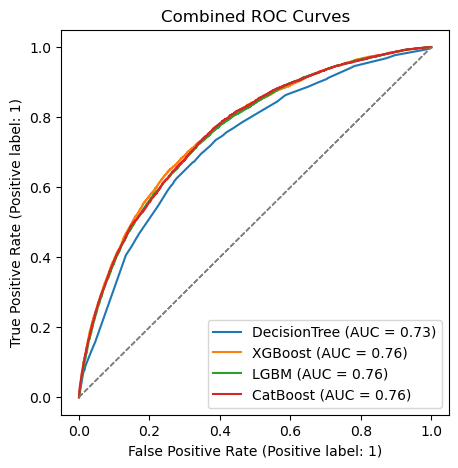

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
roc_displays = []

for model_name, y_pred in models.items():
    roc_display = RocCurveDisplay.from_predictions(y_valid, y_pred[1], name=model_name, ax=ax)
    roc_displays.append(roc_display)
    ax.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')

ax.set_title("Combined ROC Curves");

It seems that all of our boosting models perform similarly with a normalized area of 0.76. The decision tree model perfoms slightly worse. These results reflect what was obtained in the cross-validation.

Let's take a look into the F1-Scores and Recall for each of the models.

In [23]:
for model_name, y_pred in models.items():
    f1 = f1_score(y_valid, y_pred[0])
    recall = recall_score(y_valid, y_pred[0])
    print(f"{model_name}")
    print(f"F1-Score: {f1:.3f} ; Recall: {recall:.3f}")

DecisionTree
F1-Score: 0.246 ; Recall: 0.696
XGBoost
F1-Score: 0.011 ; Recall: 0.006
LGBM
F1-Score: 0.266 ; Recall: 0.676
CatBoost
F1-Score: 0.270 ; Recall: 0.664


The values of F1-Score highlight that the performance of the models is still poor (slightly above 0.24) with recall of 66%.

In terms of F1-Score, we get pretty similar results as in the cross-validation. For that we have a **recall of around 66%**. We will run a **threshold analysis** on these models, but before, let's see the results in **confusion matrices**.

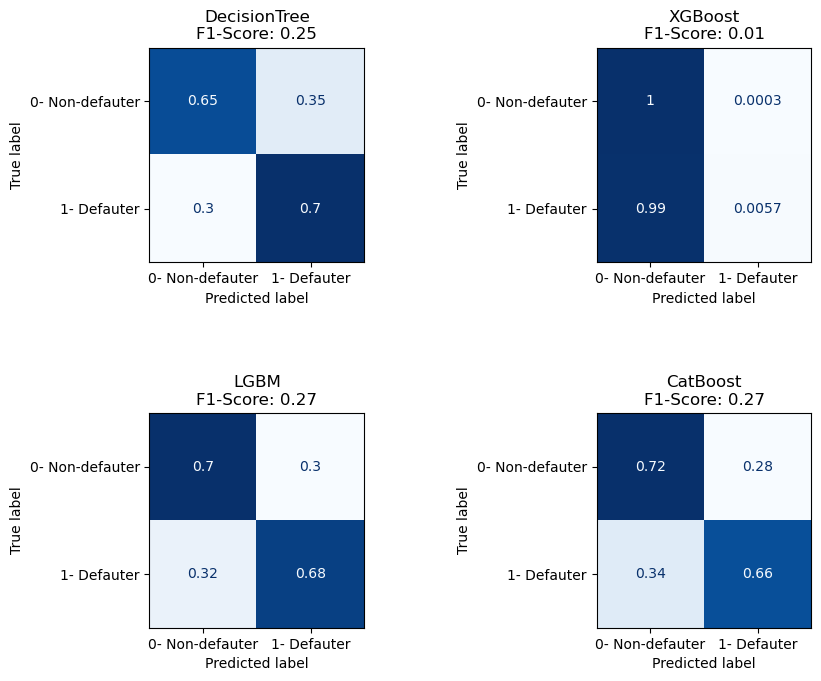

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for model_name, y_pred, ax in zip(models.keys(), models.values(), axes.flatten()):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_valid, y_pred[0], normalize='true',
                                                         cmap='Blues', ax=ax, colorbar=False,
                                                         display_labels=["0- Non-defauter", "1- Defauter"])
    f1 = f1_score(y_valid, y_pred[0])
    ax.set_title(f"{model_name}\nF1-Score: {f1:.2f}")

plt.tight_layout(pad=5)

Here we see clearly that the **XGBoost** did not perform well because it **mostly predicted values for the majority class** (0-Non-defaulters). That is a very not expected, threshold for this model.

All of the **other models** seem to present **very similar results** of precision and recall for both classes, with the **LightGBM performing a little better** in predicting correctly the class **1-Defauters**.

We jump now into a analysis of the **Precision-Recall curve** to try to find an optimal threshold for our results (but still with focus on Recall for the defaulters class).

<h2 style="color:#774CAD">Threshold Analysis</h2>

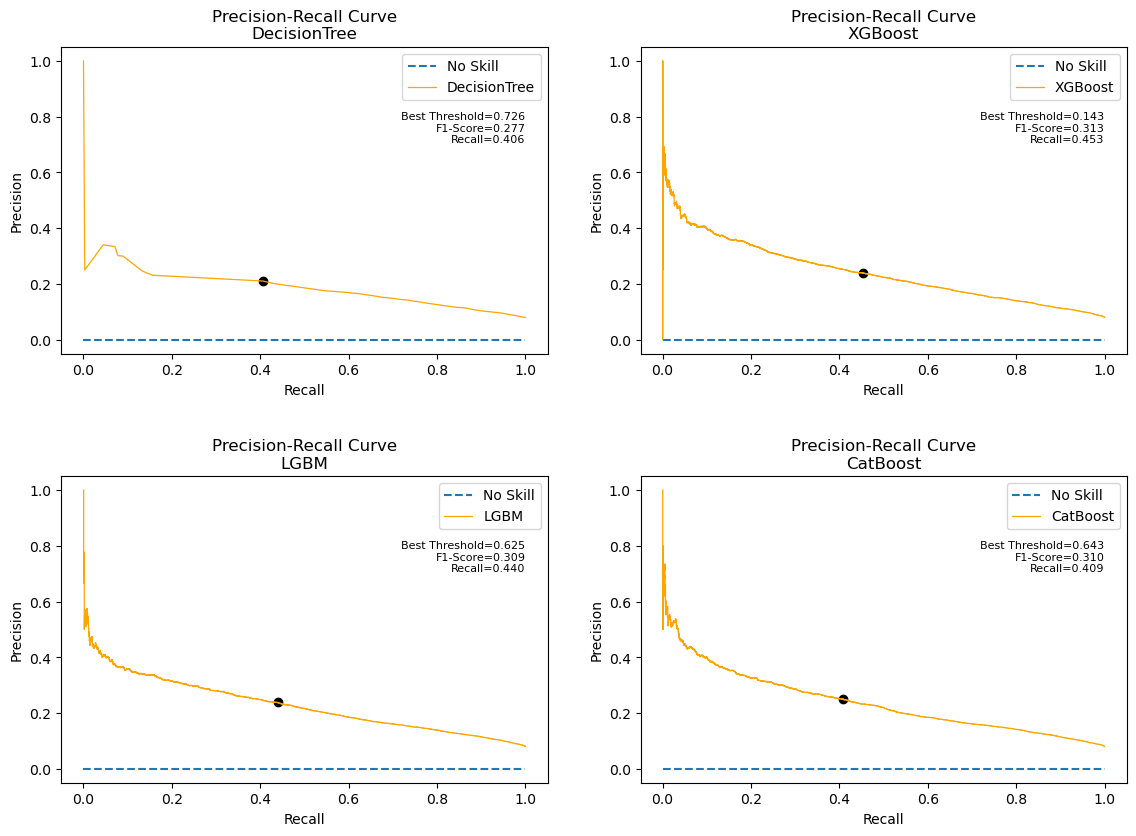

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(12, 9))
axes = axes.flatten()

for i, (model_name, result) in enumerate(results.items()):
    trained_model = result['model'].named_steps['model']
    model_select.plot_pr_curve(trained_model, X_valid, y_valid, model_name, ax=axes[i])

plt.tight_layout(pad=3)

We see here that finding the **optimal F1-Score comes with an obvious loss in Recall** for most of the models. This value drop from about 66% to 45%. In the context where we would like to predict defaulters, this change in threshold would not represent an advantage.

Something to notice here is that the curves of the XGBoost and CatBoost are higher than the other models, which depicts a slightly better precision-recall curve.

In the case of the **XGBoost**, the situation is completely different, with the standard threshold of 0.5 the levels of recall for our class of interest was 0. Let's further evaluate the thresholds for this model. **What threshold we need to achieve a similar recall as the other models (65%)?**

In [26]:
target_recall = 0.70
chosen_threshold = model_select.find_threshold_for_recall(xgb_model, X_valid, y_valid, target_recall)

Target Recall 0.7
Threshold: 0.084; Precision: 0.165


In [27]:
y_xgb_thresholded = model_select.apply_threshold(xgb_model, X_valid, chosen_threshold)

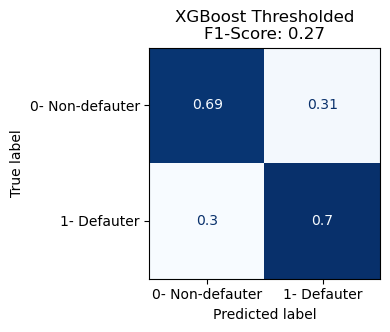

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))

cm_display = ConfusionMatrixDisplay.from_predictions(y_valid, y_xgb_thresholded, normalize='true',
                                                     cmap='Blues', ax=ax, colorbar=False,
                                                     display_labels=["0- Non-defauter", "1- Defauter"])
f1 = f1_score(y_valid, y_xgb_thresholded)
ax.set_title(f"XGBoost Thresholded\nF1-Score: {f1:.2f}");

The above threshold seems to provide a 70% ability to predict defaulters on the validation dataset.

Let's also take a look at the area under the ROC curves and see to check if we can find a better model through there.

<h2 style="color:#774CAD">Feature Importance</h2>

We can now evaluate which features were the most important for our model's.

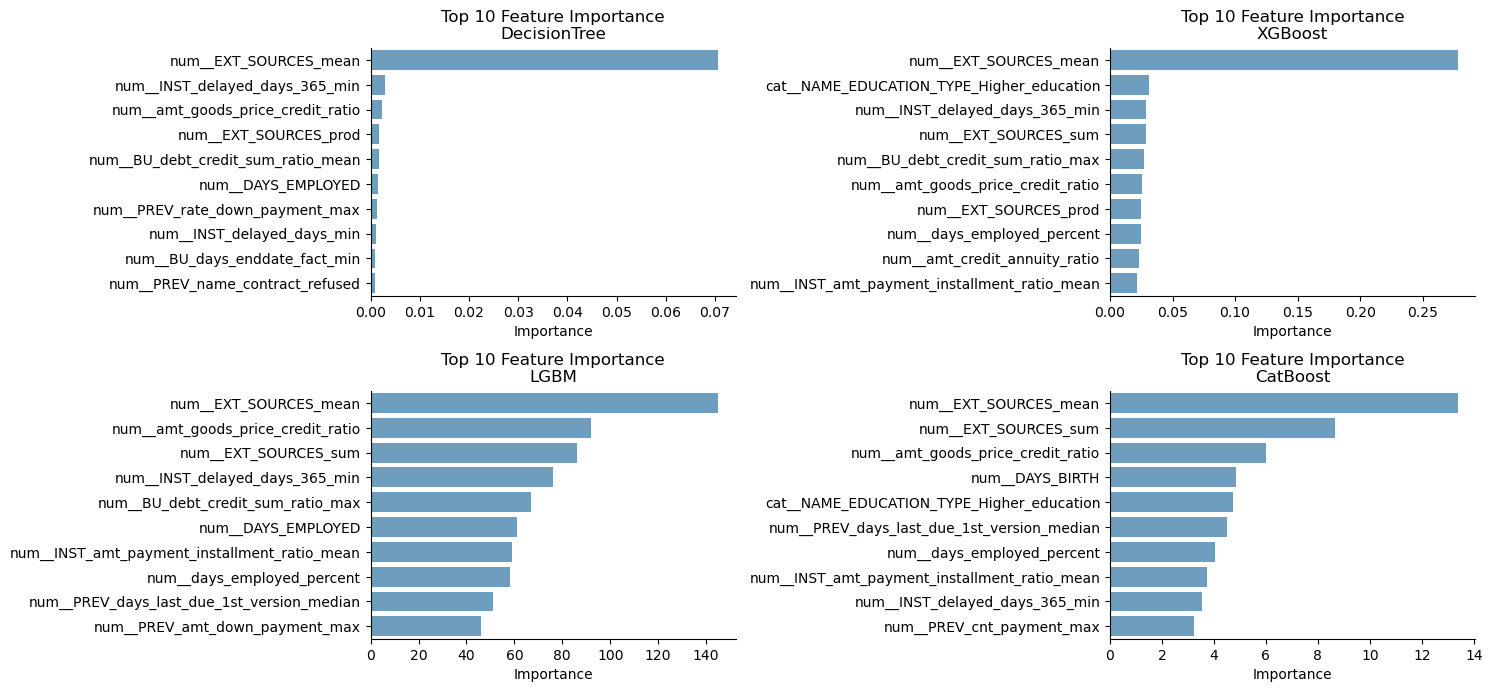

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7))
axes = axes.flatten()

for i, (model_name, result) in enumerate(results.items()):
    trained_model = result['model'].named_steps['model']
    model_select.plot_feature_importance(trained_model, X_valid, y_valid, ax=axes[i], top_n=10, color='tab:blue', model_name=model_name)

plt.tight_layout(pad=1)

We see that the decision tree probably based most of its decisions on the sum of the External Sources. All the boosting models placed in 1st the mean of these sources.

All of the models present some of the engineered features on the top 10, highlighting the importance of this step.

<h2 style="color:#774CAD">Force plots</h2>

We have already gathered some information about how the models are making predictions, to what extent they work and which features are the most important for each of them.

For now, all of our models present similar results (including the XGBoost after threshold setting).

We can now **generate a visualizations that will show how a feature value is impacting the model predictions**. We will not perform this analysis on the decision tree as it presented a slightly lesser ROC AUC.

In [30]:
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_valid)

print("XGBClassifier")
shap.force_plot(explainer_xgb.expected_value, shap_values_xgb[0,:], X_valid.iloc[0,:])

XGBClassifier


The results for the XGBoost is being heavily pushed to negative, what is expected as here no threshold was applied. It is not clear if such a thing can be implemented here.

In [31]:
explainer_catb = shap.TreeExplainer(catb_model)
shap_values_catb = explainer_catb.shap_values(X_valid)

print("CatBoostClassifier")
shap.initjs()
shap.force_plot(explainer_catb.expected_value, shap_values_catb[0,:], X_valid.iloc[0,:])

CatBoostClassifier


In [32]:
explainer_lgbm = shap.TreeExplainer(lgbm_model)
shap_values_lgbm = explainer_lgbm.shap_values(X_valid)

print("LGBMClassifier")
shap.force_plot(explainer_lgbm.expected_value[1], shap_values_lgbm[1][0,:], X_valid.iloc[0,:])

LGBMClassifier


The evaluation for both Catboost and LightGBM are very similar and the SHAP value also do not differ very much (0.63 and 0.54 respectively).

For the LightGBM:
- The prediction is being pushed closer to 1(-Defauters) specially because of the features "EXT_SOURCES_mean", "amt_goods_price_credit_ratio" and many other (in red).
- On the other side (in blue), pushing the predictions to 0(-Non-Defauters) are "BU_debt_credit_sum_ratio_max", "NAME_EDUCATION_TYPE_Higher_education"

For the CatBoost:
- "EXT_SOURCES_mean" also pushes very much towards class 1.
- "NAME_EDUCATION_TYPE_Higher_education" is the most important features pushing towards 0.

This already highlight some very important observation: People with **low external sources** should not be given a loan, they **are very likely to be defaulters**. Clients with **Higher Education tend to pay their loans on time**.

<h1 style="color:#774CAD">Final Evaluation</h1>

After, careful evaluation of our models, we see that the 3 boosting models behaved similarly and in theory can be implemented. The XGBoost presents the best Precision/Recall Curve and therefore is likely to give us the best results (after being thresholded).

As the object of this project is to deploy different machine learning models and the presented results are not so different, we will run our 3 models on our test data.

In [33]:
y_xgb_test = model_select.apply_threshold(xgb_model, X_test, chosen_threshold)
y_catb_test = catb_model.predict(X_test)
y_lgbm_test = lgbm_model.predict(X_test)

models_test = {
    'XGBoost': y_xgb_test,
    'LGBM': y_lgbm_test,
    'CatBoost': y_catb_test,
}

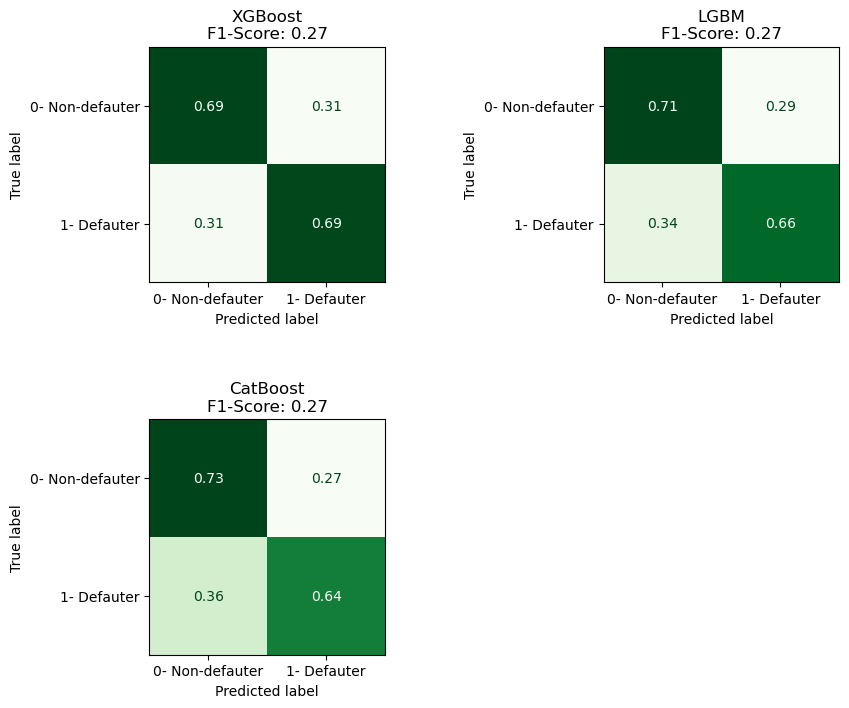

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

for model_name, y_pred, ax in zip(models_test.keys(), models_test.values(), axes.flatten()):
    cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize='true',
                                                         cmap='Greens', ax=ax, colorbar=False,
                                                         display_labels=["0- Non-defauter", "1- Defauter"])
    f1 = f1_score(y_test, y_pred)
    ax.set_title(f"{model_name}\nF1-Score: {f1:.2f}")

fig.delaxes(axes[1, 1])
plt.tight_layout(pad=4)

<h1 style="color:#774CAD">Model Deployment</h1>

A full deployment of the models was not completely possible. I ran into problems with one of the One-Hot-Encoded Features and could not get through this.

I imagine the error was due to some of my custom transformers and the way that I was sending the data through my processes. 

In the end, the **LightGBM and CatBoost were deployed only for the processed data**.

In [35]:
import pickle

with open('app/preprocess_and_drop_features-0.1.0.pkl', 'wb') as file:
    pickle.dump(preprocess_and_drop_features, file)

with open('app/xgb_model-0.1.0.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)

with open('app/catb_model-0.1.0.pkl', 'wb') as file:
    pickle.dump(catb_model, file)

with open('app/lgbm_model-0.1.0.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)

Sample code to export mode and median values for features, as start for model.

In [36]:
dfs = [df_train, df_previous, df_installments, df_bureau]
dfs_names = ['df_train', 'df_previous', 'df_installments', 'df_bureau'] 

result_frames = []

for df, df_name in zip(dfs, dfs_names):
    numeric_median = df.select_dtypes(include=['float64', 'int64']).median()
    object_mode = df.select_dtypes(include='object').mode().T.iloc[0] if not df.select_dtypes(include='object').empty else pd.Series()

    result_df = pd.concat([numeric_median, object_mode], axis=0)
    result_df.to_csv(f'data/{df_name}_columns_median.csv', index=True)


In [37]:
#X_train.describe()

In [38]:
#pd.set_option('display.max_rows', 130)
#print(pd.DataFrame(df_train.dtypes))

<h1 style="color:#774CAD">Feasability Analysis</h1>

This analysis was performed for our LightGBM model results. Only the test dataset was used, so one can expect a much lower sum of issued credit than in the initial analysis of the necessity of the model.

In [81]:
money_df = (
    df_test[["SK_ID_CURR", "TARGET", "AMT_CREDIT"]]
    .merge(pd.Series(y_lgbm_test, name='y_hat'), left_index=True, right_index=True)
    .rename(columns={"TARGET": "y"})
)
money_df.head()

,SK_ID_CURR,y,AMT_CREDIT,y_hat
0,254477,0,199080.000,0
1,223318,0,417024.000,0
2,357636,0,1080000.000,0
3,232281,0,275040.000,1
4,175275,0,1223010.000,0


In [132]:
print(f"Sum of given credit on the test data: ${money_df['AMT_CREDIT'].sum():,.2f}")

Sum of given credit on the test data: $55,365,306,399.00


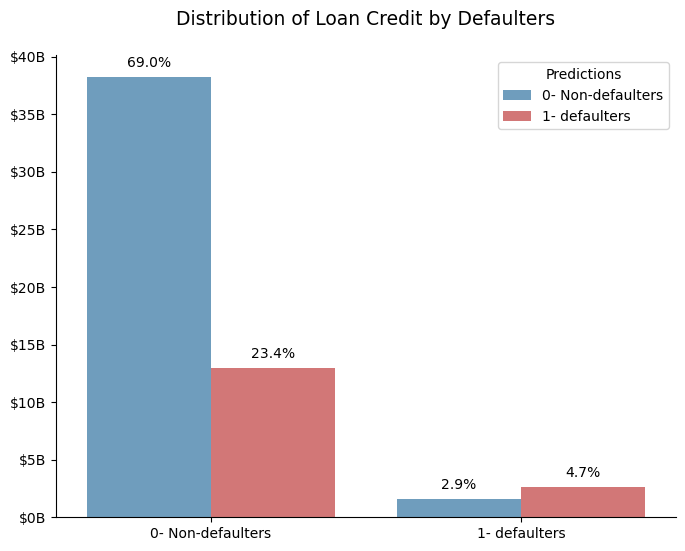

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(data=money_df, x='y', y='AMT_CREDIT', hue='y_hat', ax=ax, estimator="sum", errorbar=None, palette=['tab:blue', 'tab:red'], alpha=0.7)

total_height = sum([p.get_height() for p in ax.patches])
for p in ax.patches[:-2]:
    percentage = (p.get_height() / total_height) * 100
    ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=10)

ax.set(ylabel="", xlabel="")
ax.set_title("Distribution of Loan Credit by Defaulters\n", fontsize=13.5)
ax.set_xticks(ticks=[0, 1], labels=["0- Non-defaulters", "1- defaulters"])
ax.legend(title='Predictions', labels=["0- Non-defaulters", "1- defaulters"])

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x/1e9:.0f}B"))
sns.despine()

The proportions highlight that our model is rejecting about 23.4% of applied credit by Non-defaulters, as we evaluate bellow, this value represents about 13 Billion dollars of non-issued credit. This is directly translated as money loss for our bank institution.

With our model, we will correctly not issue 4.7% of default credits ($2.6 Bi), but still provide about 2.9% ($1.6 Bi).

In [103]:
value_lost_non_defaulters = money_df.loc[(money_df['y'] == 0) & (money_df['y_hat'] == 1), 'AMT_CREDIT'].sum()
value_gained_non_defaulters = money_df.loc[(money_df['y'] == 0) & (money_df['y_hat'] == 0), 'AMT_CREDIT'].sum()

value_lost_defaulters = money_df.loc[(money_df['y'] == 1) & (money_df['y_hat'] == 0), 'AMT_CREDIT'].sum()
value_not_lost_defaulters = money_df.loc[(money_df['y'] == 1) & (money_df['y_hat'] == 1), 'AMT_CREDIT'].sum()

print("Non-defaulters")
print(f"Issued Credit Non-Defaulters: ${value_gained_non_defaulters:,.2f}")
print(f"Value Lost by Rejecting Non-Defaulters: ${value_lost_non_defaulters:,.2f}\n")
print("Defaulters")
print(f"Issued Credit True Defaulters: ${value_lost_defaulters:,.2f}")
print(f"Value Gained by Rejecting True Defaulters: ${value_not_lost_defaulters:,.2f}\n")
print(f"Total money gained or not lost: ${value_gained_non_defaulters + value_not_lost_defaulters:,.2f}")
print(f"Total money lost: ${value_lost_non_defaulters + value_lost_defaulters:,.2f}")


Non-defaulters
Issued Credit Non-Defaulters: $38,217,772,917.00
Value Lost by Rejecting Non-Defaulters: $12,956,082,079.50

Defaulters
Issued Credit True Defaulters: $1,586,499,286.50
Value Gained by Rejecting True Defaulters: $2,604,952,116.00

Total money gained or not lost: $40,822,725,033.00
Total money lost: $14,542,581,366.00


The results are quite discouraging since we got low values of precision and recall.

This model could still be applied, if there is always a credit expert who will evaluate rejected applications and decide if they should really be rejected or not. Many ways to improve the model results are discussed in the next section.

In [133]:
#money_df.to_csv("data/money_df.csv", index=False)

<h1 style="color:#774CAD">Conclusion</h1>

Our machine learning boosting models achieve results ROC AUC values around 0.76, having for the choosen/given threshold Recall slightly above 65%.

After all this evaluation, we know that our models are far from perfect and that there is a lot of room for improvement. Some conclusions on the most important features can be however made:
- **External sources play a key role** in a way that if a client has bad sources they can be already denied a loan;
- Another vital feature is the **ratio between the requested amount and the final credit amount** (in the previous application);
- The **Higher Education** tends to push clients towards being good payers;
- Another feature that seems to define good payers is **ratio between the Current debt and Current credit amount** (in the Credit Bureau);

How to improve the model results:
- Invest time on the inexplored dataframes;
- Bring more aggregated features from the previous application/installments to the model;
- Invest computational resources to generate features automatically (too much time invested on feature engineering);
- Compute interest rates;
- Create new aggregations for subsamples of the dataframes, i.e. NAME_PRODUCT_TYPE == "Approved"/"Cancelled", or CREDIT_ACTIVE == "bad debt"; 
- Try to impute values and check if there is increase in performance;

General improvements:
- To improve the workflow, some investiment can be done on the pipelines and creating mechanisms to integrate the data better;
- Correlations can be transformed into a function and put in EDA.py.
- Deployment of the initial features and passing through the pipelines.